<a href="https://colab.research.google.com/github/koreahong/parking_lot_analysis/blob/main/%EA%B3%A0%EB%A0%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브러리 불러오기

In [3]:
import os, sys
my_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/머신러닝_실전예제/colab_library', my_path)
sys.path.insert(0, my_path)

In [ ]:
!pip install --target=$my_path pycaret
!pip install --target=$my_path category_encoders
!pip install --target=$my_path catboost

In [2]:
import sys
sys.path.append('/content/drive/My Drive/머신러닝_실전예제/colab_library')

In [ ]:
#download pont
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv 
!rm ~/.cache/matplotlib -rf 

In [4]:
import pandas as pd
import numpy as np
import copy

#시각화
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

#통계
from scipy.stats import skew
from scipy  import stats

#데이터전처리
from sklearn.preprocessing import OneHotEncoder

#머신러닝 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

#경고무시
import warnings
warnings.filterwarnings("ignore")

#폰트설정
plt.rc('font', family='NanumBarunGothic') 

In [5]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

In [6]:
#mount google drive 
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
train = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/train.csv")

In [8]:
test = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/test.csv")

In [9]:
sub = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/sample_submission.csv")

- train 데이터 -> 임대보증금, 임대료, 버스정류장 수 등 null값 존재

- test 데이터 -> 임대보증금, 임대료, 지하철 수  null값 존재

### 어려운 컬럼 이름 간편하게 변경

In [10]:
train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철', \
                      '도보 10분거리 내 버스정류장 수':'버스'}, inplace=True)

In [ ]:
test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철', \
                      '도보 10분거리 내 버스정류장 수':'버스'}, inplace=True)

### 임대료, 임대보증금 int로 변환

In [11]:
train['임대료'] = train['임대료'].fillna(-1)
train['임대보증금'] = train['임대보증금'].fillna(-1)

In [12]:
train['임대료'] = train['임대료'].replace('-', -1)
train['임대보증금'] = train['임대보증금'].replace('-', -1)

In [13]:
test['임대료'] = test['임대료'].fillna(-1)
test['임대보증금'] = test['임대보증금'].fillna(-1)

In [14]:
test['임대료'] = test['임대료'].replace('-', -1)
test['임대보증금'] = test['임대보증금'].replace('-', -1)

In [15]:
train['임대료'] = train['임대료'].astype(int)
train['임대보증금'] = train['임대보증금'].astype(int)

In [16]:
test['임대료'] = test['임대료'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

In [ ]:
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [17]:
test.iloc[196, 8] = 'A'

In [18]:
test.iloc[258, 8] = 'C'

## 히트맵 확인

In [19]:
none_duplicate = train.drop_duplicates('단지코드', keep='first')

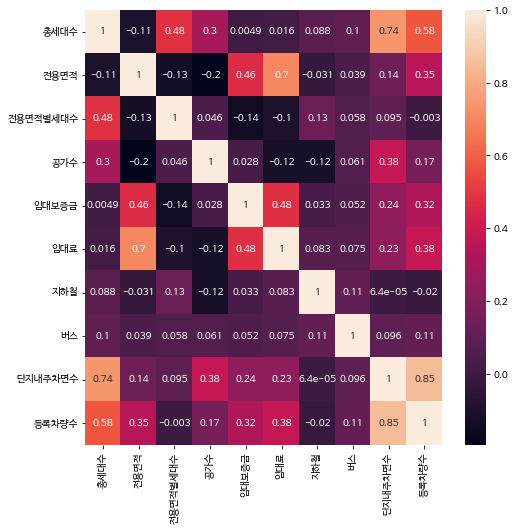

In [20]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white")
sns.heatmap(none_duplicate.corr(), annot=True)

- 총세대수, 전용면적, 임대보증금, 임대료, 단지내주차면수가 등록차량수와 밀접한 연관이 있음

In [21]:
train_copy = train.copy()
test_copy = test.copy()

### 가정1: 단지내에 상가가 있으면 주차장 수가 줄어들 것이다.

In [ ]:
code = train_copy[train_copy.임대건물구분 == '상가'].단지코드.unique()

In [ ]:
train_copy['상가유무'] = 1
train_copy['상가유무'] = train_copy.단지코드.apply(lambda x: '상가있음' if x in code else '상가없음')

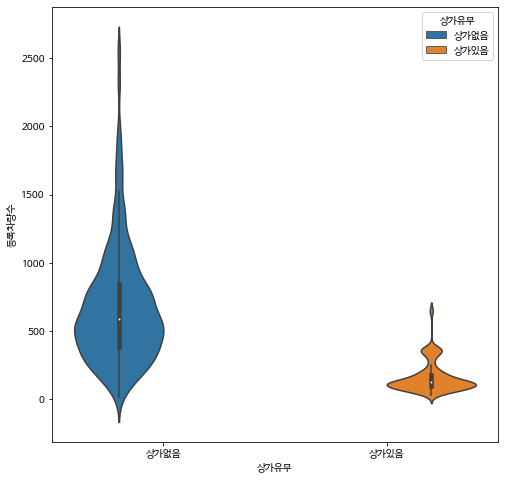

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white")
sns.violinplot(x="상가유무", y="등록차량수", data=train_copy, hue="상가유무")

- 단지내에 상가유무에 따라서 유의미한 차이가 있음 -> 상가로 인해서 주차장 면적이 줄어드는 것으로 판단

### 가정2: 전용면적합, 평균이 크고 단지내 아파트수가 많으면 등록차량수가 많아지지 않을까?

In [86]:
temp = train_copy[train_copy.임대건물구분 == '아파트'].groupby('단지코드').agg({'전용면적':['mean', 'sum', 'count'], '전용면적별세대수':'mean', '등록차량수':'mean'}).reset_index()

In [87]:
temp.columns = ['단지코드', '전용면적평균',  '전용면적총합', '단지내아파트개수', '전용면적별세대수평균', '등록차량수']

In [88]:
temp.corr()

,전용면적평균,전용면적총합,단지내아파트개수,전용면적별세대수평균,등록차량수
전용면적평균,1.000000,0.412434,0.009750,-0.132637,0.425299
전용면적총합,0.412434,1.000000,0.872935,-0.364646,0.513212
단지내아파트개수,0.009750,0.872935,1.000000,-0.396460,0.400387
전용면적별세대수평균,-0.132637,-0.364646,-0.396460,1.000000,0.084180
등록차량수,0.425299,0.513212,0.400387,0.084180,1.000000


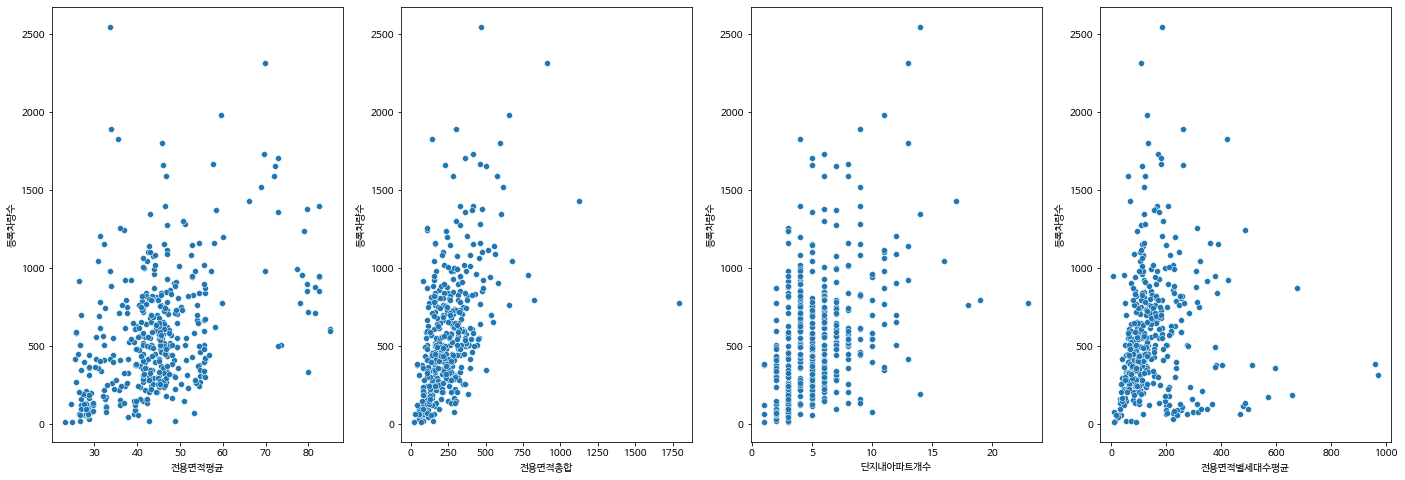

In [89]:
fig , ax = plt.subplots(figsize=(24,8))
fig.set_facecolor('white')
count = 1
num = len(temp.columns[1:-1])
for i in temp.columns[1:-1]:
  plt.subplot(1, num, count)
  sns.scatterplot(x=i, y="등록차량수", data=temp)
  count+=1

일부 단지내 아파트개수가 많다는 것을 확인핧 수 있음 10개 이상인 곳들 확인

In [90]:
temp[(temp.단지내아파트개수 > 10) & (temp.등록차량수 > 2000)]

,단지코드,전용면적평균,전용면적총합,단지내아파트개수,전용면적별세대수평균,등록차량수
81,C1350,69.866923,908.27,13,107.769231,2315.0
84,C1363,33.552857,469.74,14,183.428571,2550.0


In [91]:
train_copy[train_copy.단지코드 == 'C1350']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2331,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,-1,-1,NaN,6.0,1636.0,2315.0
2332,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,-1,-1,NaN,6.0,1636.0,2315.0
2333,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,-1,-1,NaN,6.0,1636.0,2315.0
2334,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,-1,-1,NaN,6.0,1636.0,2315.0
2335,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,-1,-1,NaN,6.0,1636.0,2315.0
2336,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,-1,-1,NaN,6.0,1636.0,2315.0
2337,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,-1,-1,NaN,6.0,1636.0,2315.0
2338,C1350,1401,아파트,대전광역시,공공임대(10년),51.99,106,2.0,A,28013000,408600,NaN,6.0,1636.0,2315.0
2339,C1350,1401,아파트,대전광역시,공공임대(10년),59.91,13,2.0,A,37474000,519350,NaN,6.0,1636.0,2315.0
2340,C1350,1401,아파트,대전광역시,공공임대(10년),59.92,223,2.0,A,37385000,516130,NaN,6.0,1636.0,2315.0


- 문제1: 전용면적이 같은데 세대수가 다르면 다른 아파트일까?
- 문제2: 전용면적이 소숫점만 다르면 다른 아파트일까?

공급유형와 전용면적 실수자리까지 동일하면 같은 아파트로 취급하고 위의 상관관계를 다시 확인해보자

In [105]:
train_new = train_copy.copy()

In [106]:
train_new['전용면적'] = train_new['전용면적'].apply(math.floor)

In [107]:
live_people = train_new.groupby(train_new.columns[:6].tolist()).agg({'전용면적별세대수':'sum'}).reset_index()

In [108]:
train_new = train_new.drop_duplicates(train_new.columns[:6].tolist(), keep='first').sort_values('단지코드').reset_index(drop=True)

In [109]:
train_new.전용면적별세대수 = live_people.전용면적별세대수

In [110]:
train_new.head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C1000,566,아파트,충청북도,국민임대,39,419,10.0,A,10803000,96030,0.0,1.0,438.0,481.0
1,C1000,566,아파트,충청북도,국민임대,46,72,10.0,A,14404000,129640,0.0,1.0,438.0,481.0
2,C1000,566,아파트,충청북도,국민임대,51,75,10.0,A,15604000,150040,0.0,1.0,438.0,481.0
3,C1004,521,상가,충청남도,임대상가,23,1,3.0,D,-1,-1,NaN,2.0,153.0,93.0
4,C1004,521,상가,충청남도,임대상가,19,2,3.0,D,-1,-1,NaN,2.0,153.0,93.0
5,C1004,521,상가,충청남도,임대상가,22,2,3.0,D,-1,-1,NaN,2.0,153.0,93.0
6,C1004,521,상가,충청남도,임대상가,27,1,3.0,D,-1,-1,NaN,2.0,153.0,93.0
7,C1004,521,상가,충청남도,임대상가,31,4,3.0,D,-1,-1,NaN,2.0,153.0,93.0
8,C1004,521,아파트,충청남도,영구임대,39,1,3.0,C,4682000,104180,NaN,2.0,153.0,93.0
9,C1004,521,상가,충청남도,임대상가,32,1,3.0,D,-1,-1,NaN,2.0,153.0,93.0


In [111]:
temp = train_new[train_new.임대건물구분 == '아파트'].groupby('단지코드').agg({'전용면적':['mean', 'sum', 'count'], '전용면적별세대수':'mean', '등록차량수':'mean'}).reset_index()

In [112]:
temp.columns = ['단지코드', '전용면적평균',  '전용면적총합', '단지내아파트개수', '전용면적별세대수평균', '등록차량수']

In [113]:
temp.corr()

,전용면적평균,전용면적총합,단지내아파트개수,전용면적별세대수평균,등록차량수
전용면적평균,1.000000,0.442908,-0.200500,0.246484,0.414580
전용면적총합,0.442908,1.000000,0.755886,-0.067874,0.474942
단지내아파트개수,-0.200500,0.755886,1.000000,-0.207411,0.254283
전용면적별세대수평균,0.246484,-0.067874,-0.207411,1.000000,0.588281
등록차량수,0.414580,0.474942,0.254283,0.588281,1.000000


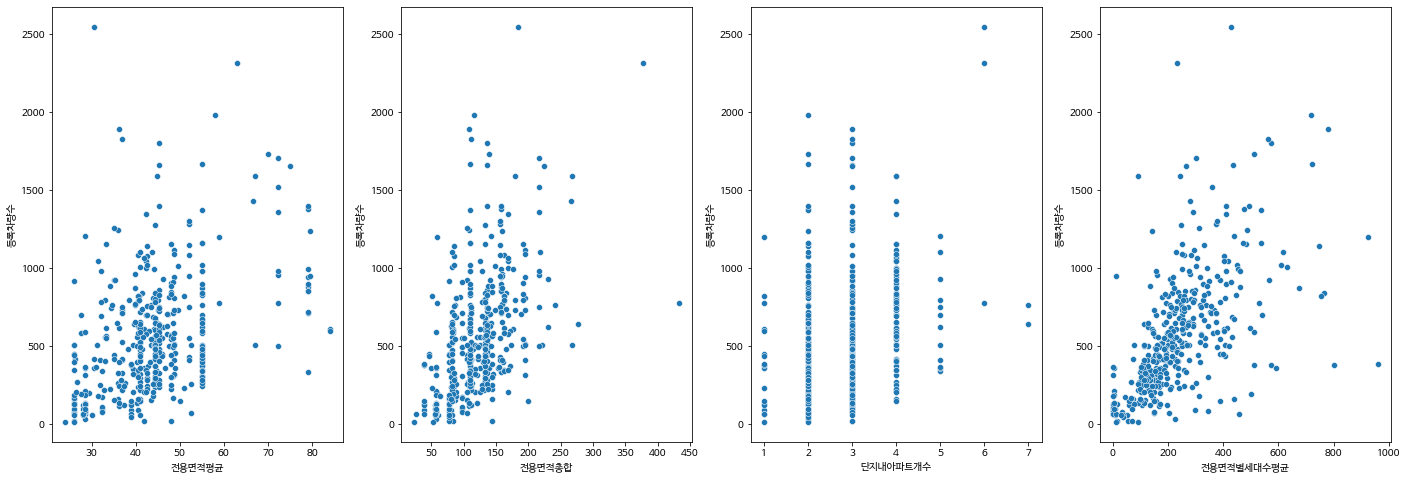

In [114]:
fig , ax = plt.subplots(figsize=(24,8))
fig.set_facecolor('white')
count = 1
num = len(temp.columns[1:-1])
for i in temp.columns[1:-1]:
  plt.subplot(1, num, count)
  sns.scatterplot(x=i, y="등록차량수", data=temp)
  count+=1

전용면적별세대수 평균을 제외한 전용면적총합, 평균, 단지내 아파트개수가 많을 수록 등록차량수가 많다는 것을 확인할 수 있음   
-> 아파트개수가 타겟변수와 강한상관관계를 나타내지 않고 다른 변수들과 강한상관관계를 가짐으로 생성 x

파생변수(전용면적 정수자리기준 그룹핑)  
- 전용면적평균
- 전용면적총합
- 전용면적별세대수평균

In [ ]:
age_info = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/age_gender_info.csv")

In [ ]:
age_info.head()

In [ ]:
age_info.info()

In [ ]:
train_copy.drop('등록차량수', axis=1, inplace=True)

In [ ]:
X = train_copy.drop(['단지코드', '비례등록차량수'], axis=1)
y = train_copy['비례등록차량수']

In [ ]:
test_co = test_copy.iloc[:,1:].copy()

In [ ]:
categorical_feats = X.dtypes[X.dtypes == 'object'].index

In [ ]:
features_index = X.dtypes[X.dtypes != 'object'].index

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
X[categorical_feats] = encoder.fit_transform(X[categorical_feats], y)
test_copy[categorical_feats] = encoder.transform(test_copy[categorical_feats])

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 1

target = '등록차량수'
X_test = test_co.copy()

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros(X.shape[0])
cat_pred_test = np.zeros(X_test.shape[0])
cat_cols = categorical_feats.tolist()
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostRegressor()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict(X_valid)
  cat_pred_test += model_cat.predict(X_test) / n_fold
  print(f'CV MAE Score: {mean_absolute_error(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\t MAE: {mean_absolute_error(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.055805
0:	learn: 103.3382162	test: 100.0801615	best: 100.0801615 (0)	total: 5.4ms	remaining: 5.4s
100:	learn: 26.0371270	test: 32.2693814	best: 32.2693814 (100)	total: 591ms	remaining: 5.26s
200:	learn: 20.6508102	test: 29.4452570	best: 29.4452570 (200)	total: 1.14s	remaining: 4.54s
300:	learn: 17.2508608	test: 27.1604252	best: 27.1604252 (300)	total: 1.72s	remaining: 4s
400:	learn: 14.6885910	test: 25.4070044	best: 25.3910558 (397)	total: 2.31s	remaining: 3.45s
500:	learn: 12.8636899	test: 24.3903773	best: 24.3903773 (500)	total: 2.87s	remaining: 2.86s
600:	learn: 11.3708321	test: 23.1835368	best: 23.1835368 (600)	total: 3.41s	remaining: 2.26s
700:	learn: 10.2156200	test: 22.4793523	best: 22.4793523 (700)	total: 3.95s	remaining: 1.69s
800:	learn: 9.1287566	test: 21.7124930	best: 21.7073259 (797)	total: 4.49s	remaining: 1.11s
900:	learn: 8.2641574	test: 21.4154001	best: 21.4154001 (900)	total: 5.03s	remaining: 553ms
99

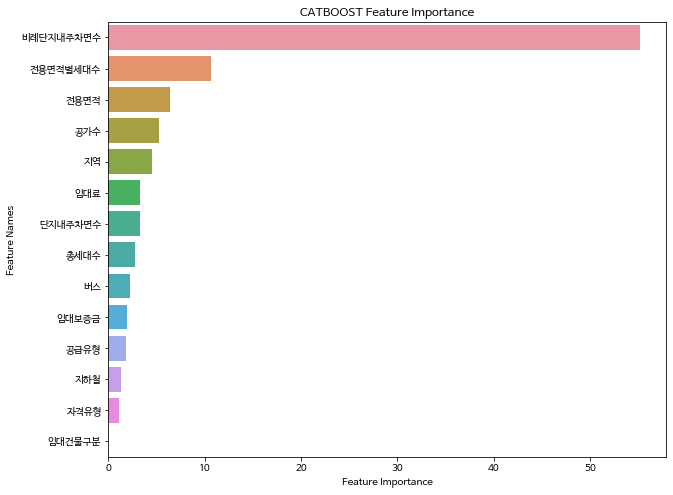

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    fig = plt.figure(figsize=(10,8))
    fig.set_facecolor("white")
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
result = pd.DataFrame(cat_pred_test)

In [ ]:
result['단지코드'] = test['단지코드']

In [ ]:
result = result.groupby('단지코드').sum().reset_index()
result.columns = ['code', 'num']

In [ ]:
sorter = sub['code']

In [ ]:
sorterIndex = dict(zip(sorter, range(len(sorter))))

In [ ]:
result['Rank'] = result['code'].map(sorterIndex)

In [ ]:
result.sort_values('Rank', inplace=True)

In [ ]:
sub = result.iloc[:, :-1]

In [ ]:
sub

,code,num
10,C1072,634.928130
13,C1128,1178.752153
44,C1456,529.769653
83,C1840,465.739497
38,C1332,1014.867228
...,...,...
132,C2456,236.407437
28,C1266,420.112394
103,C2152,37.733406
29,C1267,362.776939


In [ ]:
import os
path = "/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/result/"
file_list = os.listdir(path)
file_list_csv = [file for file in file_list if file.endswith(".csv")]
num = len(file_list_csv) + 1

In [ ]:
sub.to_csv(path + "result" + str(num) + ".csv", index=False)

# 효과없음

이런 생각도 할 수 있다.  
동일 단지코드내에 전용면적별세대수에 비례하지 않을까

In [ ]:
# 등록차량수, 단지내주차면수를 전용면적별세대수 비율에 맞추기
train_copy['비례단지내주차면수'] = round(train_copy['단지내주차면수'] * train_copy['전용면적별세대수'].div(train_copy.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum())))
train_copy['비례등록차량수'] = round(train_copy['등록차량수'] * train_copy['전용면적별세대수'].div(train_copy.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum())))

In [ ]:
test_copy['비례단지내주차면수'] = round(test_copy['단지내주차면수'] * test_copy['전용면적별세대수'].div(test_copy.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum())))

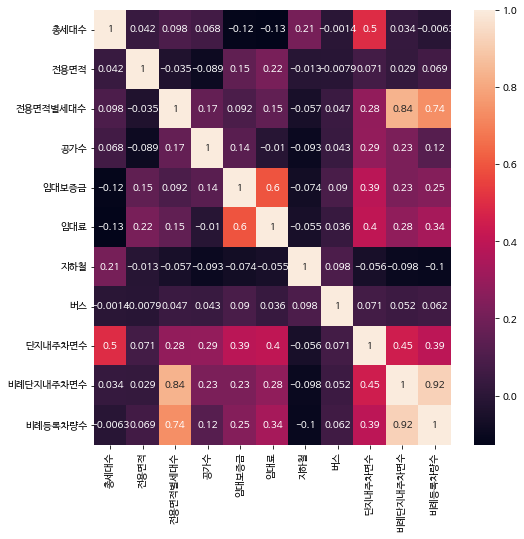

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white")
sns.heatmap(train_copy.corr(), annot=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

n_estimators: 200, max_depth: 5, 결정계수 : ', 0.9204825482256224
n_estimators: 200, max_depth: 10, 결정계수 : ', 0.9705054273075427
n_estimators: 200, max_depth: 30, 결정계수 : ', 0.9735192254136176
n_estimators: 200, max_depth: 50, 결정계수 : ', 0.9735192254136176
n_estimators: 200, max_depth: 100, 결정계수 : ', 0.9735192254136176
n_estimators: 200, max_depth: 200, 결정계수 : ', 0.9735192254136176
n_estimators: 300, max_depth: 5, 결정계수 : ', 0.9201347482994787
n_estimators: 300, max_depth: 10, 결정계수 : ', 0.9702036091059068
n_estimators: 300, max_depth: 30, 결정계수 : ', 0.9732353335079535
n_estimators: 300, max_depth: 50, 결정계수 : ', 0.9732353335079535
n_estimators: 300, max_depth: 100, 결정계수 : ', 0.9732353335079535
n_estimators: 300, max_depth: 200, 결정계수 : ', 0.9732353335079535
n_estimators: 400, max_depth: 5, 결정계수 : ', 0.9197769191990927
n_estimators: 400, max_depth: 10, 결정계수 : ', 0.9704917348309553
n_estimators: 400, max_depth: 30, 결정계수 : ', 0.9734845335159082
n_estimators: 400, max_depth: 50, 결정계수 : ', 0.97348453

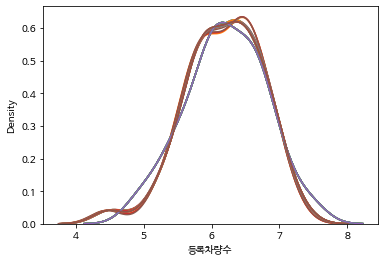

In [ ]:
for i in (200, 300, 400):
  for j in (5, 10, 30, 50, 100, 200):
    model = RandomForestRegressor(n_estimators = i, max_depth=j, random_state = 15)
    model.fit(X_train, y_train)

    relation_square = model.score(X_train, y_train)
    print(f"n_estimators: {i}, max_depth: {j}, 결정계수 : ', {relation_square}")
    
    y_p = model.predict(X_test)
    
    ax1 = sns.distplot(y_test, hist = False, label = 'y_실제')
    ax2 = sns.distplot(y_p, hist = False, label = 'y_예측')


# 결과처리

In [ ]:
sorter = test['단지코드'].unique()

In [ ]:
sorterIndex = dict(zip(sorter, range(len(sorter))))

In [ ]:
result = pd.DataFrame()
result['code'] = test['단지코드'].drop_duplicates(keep='first').sort_values().reset_index(drop=True)
result['num'] = np.exp(model.predict(new_test))
result['Rank'] = result['code'].map(sorterIndex)

In [ ]:
sub_ex = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/sample_submission.csv")

In [ ]:
result = result.sort_values('Rank')

In [ ]:
result[result['code'] == 'C1030']

NameError: ignored

In [ ]:
 result.drop('Rank', axis=1, inplace=True)

In [ ]:
result.to_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/submission.csv", index=False)